# clustering of strains and type naming

## steps
- get core alignment
- generate snp dists
- cluster
- retain members
- run again with previous members and new core alignment/snpdists

## be able to
- add new samples with just SNPs without re-aligning to other samples. allows us to type new samples from snps quickly. 

## requirements
* current core alignments for baseline pop - can be recreated at any time 
* current cluster membership
* snpdist matrix is recreated from a) full alignment or b) on the fly from new addition

## Refs
* https://www.biorxiv.org/content/10.1101/2023.02.03.527052v1.full

In [1]:
import sys,os,random,time,string,itertools
import json
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML
import toyplot,toytree

from btbabm import models,utils
from snipgenie import clustering,tools,plotting


/home/farrell/.local/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## simulate test data

In [ ]:
reload(models)
reload(utils)
model = models.FarmPathogenModel(F=40,C=1200,S=10,seq_length=1000)
model.run(2000)
gdf, snpdist, meta = model.get_metadata(treefile='cluster_test/tree.newick')
snpdist.to_csv('cluster_test/snpdist.csv')
meta.to_csv('cluster_test/meta.csv',index=False)
#utils.draw_tree('cluster_test/tree.newick')

In [251]:
#test data
snpdist = pd.read_csv('cluster_test/snpdist.csv',index_col=0)
meta = pd.read_csv('cluster_test/meta.csv')
treefile = 'cluster_test/tree.newick'
M=meta.set_index('id')[['species','strain']]
print (len(snpdist),len(meta))

857 857


In [4]:
reload(clustering)

def get_subset(snpdist,X,n=10,seed=10):
    #subset dist matrix
    sub = list(snpdist.sample(n, random_state=seed).index)
    S = snpdist.loc[sub,sub]
    X=X.loc[sub]
    return S,X
    
def get_subtree(S, treefile, outfile):
    from Bio import Phylo
    from copy import deepcopy

    tips = list(S.index)
    tree = Phylo.read(treefile, 'newick')
    subtree = deepcopy(tree)
    for t in tree.get_terminals():
        if t.name not in tips:
            subtree.prune(t.name)    
    Phylo.write(subtree, outfile, "newick")
    return

In [ ]:
S1,X1 = get_subset(snpdist,M,n=20)
get_subtree(S1,treefile,'sub1.newick')
utils.draw_tree('sub1.newick')

In [ ]:
S2,X2 = get_subset(snpdist,X,n=20)
S1,X1 = get_subset(S2,X2,n=15)
labels,clusters1 = clustering.dm_cluster(S1, T)

X1[scol]=labels
get_subtree(S1,treefile,'sub1.newick')
utils.draw_tree('sub1.newick',X1,scol,tip_labels=True,width=600,cmap=clustering.snp200_cmap)

In [ ]:
labels,clusters2 = clustering.dm_cluster(S2, T,clusters1)
X2[scol]=labels
get_tree(S2,'sub2.newick')
utils.draw_tree('sub2.newick',X2,scol,tip_labels=True,width=600,cmap=clustering.snp200_cmap)
cm=dict(zip(X2[scol],X2.color))
#X2.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

In [ ]:
X1.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

In [ ]:
cg = sns.clustermap(S2, cmap='Blues', row_colors=X2.color,figsize=(6,6))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)

In [9]:
def mds(S,X,st,ax=None):
    import sklearn
    from sklearn import decomposition
    from sklearn import manifold
    
    #pca = decomposition.PCA(n_components=2)
    mds = manifold.MDS(n_components=2, random_state=4,
                       normalized_stress='auto',dissimilarity='precomputed')
    P = mds.fit(S).embedding_
    #P = pca.fit_transform(pos)
    df=pd.DataFrame(S)
    colors = st.loc[X.index].color
    if ax==None:
        fig,ax = plt.subplots(figsize=(6, 5))
    sc=ax.scatter(P[:, 0], P[:, 1], c=colors, s=70, ec='black', alpha=.5)
    return

## iteratively add samples to test clusters

In [ ]:
T=7
scol='snp'+str(T)
reload(clustering)

def test_cluster_runs(X,S,T,treefile=None,n=50,steps=None, cmap=None, tip_labels=True):
    
    members= None
    if cmap==None:
        cmap = plotting.random_cmap(100)
    if steps == None:
        steps = np.arange(10,n,20)
        print (steps)
    res=[]
    i=1
    fig,ax=plt.subplots(1,len(steps),figsize=(12,3))    
    for l in steps:
        Sr = S.iloc[:l,:l].copy()
        Xr = X.iloc[:l].copy()        

        cl,members = clustering.get_cluster_levels(Sr, members, linkage='single')
        #print (members[members.level==12])
        st = clustering.generate_strain_names(cl)
        #print (st)
     
        st = Xr.merge(st,left_index=True,right_index=True)
        
        if treefile != None:
            get_subtree(Sr,treefile,'sub.newick')
            h=len(Xr)*8+100
            utils.draw_tree('sub.newick',st,scol,tip_labels=tip_labels,cmap=cmap,
                            width=500,height=h,tip_labels_style={"font-size": "12px"})
        #display(st.iloc[:,2:].style.applymap(lambda x: "background-color: %s" %cmap[x], subset=[scol]))
        #cg = sns.clustermap(Sr, cmap='Blues', row_colors=st.color,figsize=(6,6))
        #cm=dict(zip(st[scol],st.color))
        #p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=12)
        mds(Sr,Xr,st,ax=ax[i-1])        
        st['run'] = i
        i+=1
        res.append(st)
    return res, members

S1,X1 = get_subset(snpdist,M,n=30,seed=4)
res, memb = test_cluster_runs(X1,S1,T,treefile,steps=[10,15,25],cmap = clustering.snp200_cmap)
#print (res)

In [ ]:
reload(clustering)
res=[]
i=1
steps=[10,15,25]
members=None
for l in steps:
    print ('step',l)
    Sr = S1.iloc[:l,:l].copy()
    Xr = X1.iloc[:l].copy()
    labels,members = clustering.dm_cluster(Sr, 12, members, linkage='single')
    Xr[scol] = labels
    get_subtree(Sr,treefile,'sub.newick')
    h=len(Xr)*12+100
    utils.draw_tree('sub.newick',Xr,scol,tip_labels=True,cmap=clustering.snp200_cmap,
                    width=500,height=h,tip_labels_style={"font-size": "12px"})

In [ ]:
cl,members = clustering.get_cluster_levels(S1, linkage='single')
st = clustering.generate_strain_names(cl)
get_subtree(S1,treefile,'sub.newick')
#print (st.loc['nD6y1miFwR'])
reload(utils)
utils.draw_tree('sub.newick', st, scol, tip_labels=False, cmap=clustering.snp200_cmap)
mds(S1,X1,st)

In [ ]:
reload(utils)
reload(clustering)
labels,clusters = clustering.dm_cluster(snpdist, T, prevclusters)

X[scol]=labels
#print (newclusters)
cm=clustering.snp12_cmap
utils.draw_tree(treefile,X,scol,tip_labels=False,height=700)#,cmap=cm)
cg=sns.clustermap(snpdist, cmap='Blues', row_colors=X.color,xticklabels=[],figsize=(8,8))
cm=dict(zip(X[scol],X.color))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)
#X.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

In [ ]:
X.groupby(['snp200','SB']).count().sort_values('Species')[-12:]
#X.to_csv('newclusts.csv')
w=X[X[scol].isin([1,12])].index
W=snpdist.loc[w,w]
#sns.heatmap(W)
X.loc[W.index]

## ireland data

In [214]:
#ireland data
iresnpdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
iremeta = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')
iretree = '/storage/btbgenie/all_ireland_results/tree.newick'
Xire = iremeta.set_index('sample')[['Species','SB','SB1','County','county1','Year']]
print (len(iresnpdist),len(Xire))

1436 1435


In [2]:
combsnpdist = pd.read_csv('/storage/btbgenie/combined_results/snpdist.csv',index_col=0)
combmeta = pd.read_csv('/storage/btbgenie/combined_results/metadata.csv')
combtree = '/storage/btbgenie/combined_results/tree.newick'
Xcomb = combmeta.set_index('sample')[['Species','SB','SB1','County','county1','Year']]
len(Xcomb),len(combsnpdist)
combsnpdist = combsnpdist.loc[Xcomb.index,Xcomb.index]

In [ ]:
#distances within each cluster
for i, df in res[0].groupby(scol):
    print (df)
    idx=df.index
    s=S1.loc[idx,idx]
    print (i,s.max().max())

In [6]:
T=200
scol='snp'+str(T)
Si,Xi = get_subset(combsnpdist,Xcomb,n=200,seed=1)

cl,members1 = clustering.get_cluster_levels(Si)
st1 = clustering.generate_strain_names(cl)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="260.0px" viewBox="0 0 500.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9c70f87af82d4b6face4534eb120384e"> 0 110 220 330 440

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="340.0px" viewBox="0 0 500.0 340.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t72029c489f674b03be04fd1754e84ef0"> 0 110 220 330 440

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="500.0px" viewBox="0 0 500.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t01a8057ed3344be283376457daaa742c"> 0 130 260 390 520

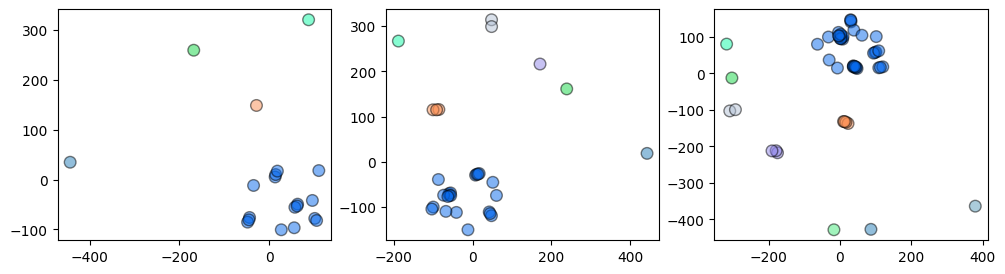

In [10]:
runs,membs = test_cluster_runs(Xi,Si,T,combtree,steps=[20,30,50],tip_labels=False)

In [ ]:
names = runs[0].index
#for st in runs:
#    print (st.loc[names])

x=pd.concat(runs)
pd.pivot_table(x,columns='run',values='snp50')


In [11]:
#combmeta[['Clonal_Complex','snp500']].dropna().drop_duplicates().sort_values('Clonal_Complex')
combmeta.groupby(['Clonal_Complex','snp500'])['sample'].count().reset_index()

,Clonal_Complex,snp500,sample
0,La1.1,10,5
1,La1.2,2,26
2,La1.3,14,64
3,La1.4,12,1
4,La1.5,1,2
5,La1.6,8,8
6,La1.7-unk4,1,1
7,La1.7-unk4,13,1
8,La1.7-unk5,1,8
9,La1.7.1,7,16
